# Flow Matching for MNIST Generation

This notebook demonstrates **Flow Matching**, a powerful generative modeling technique that learns continuous normalizing flows by regressing velocity fields. We'll implement and train a flow matching model on MNIST data.

## Mathematical Foundation

Flow matching learns a time-dependent vector field $f_\theta(z, t)$ that transports samples from a simple prior distribution $p_0$ (e.g., Gaussian noise) to the data distribution $p_1$ (MNIST images).

### Key Equations

The **continuity equation** governs the transport:
$$\frac{\partial p_t}{\partial t} + \nabla \cdot (p_t v_t) = 0$$

The **flow matching objective** minimizes:
$$\mathcal{L}(\theta) = \mathbb{E}_{t \sim \text{Unif}[0,1]} \mathbb{E}_{(x_0, x_1) \sim \pi} \left[ \|f_\theta(z(t), t) - (x_1 - x_0)\|^2 \right]$$

where $z(t) = (1-t)x_0 + tx_1$ is the straight-line interpolation path.

The **generation ODE** is:
$$\frac{dz}{dt} = f_\theta(z, t), \quad z(0) \sim p_0$$

In [1]:
# Install required packages
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = [
    "torch",
    "torchvision",
    "matplotlib",
    "numpy",
    "tqdm",
    "scipy"
]

# Install packages
for package in required_packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

print("\nAll packages installed successfully!")

✓ torch already installed
✓ torchvision already installed
✓ matplotlib already installed
✓ numpy already installed
✓ tqdm already installed
✓ scipy already installed

All packages installed successfully!


In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from tqdm.auto import tqdm  # use notebook-friendly tqdm
import math
from scipy.integrate import solve_ivp

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Prefer CUDA, then Apple MPS, else CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Note: avoid torch.set_default_tensor_type; move tensors/models explicitly to device

Using device: cuda


In [3]:
# Data loading and preprocessing
def load_mnist_data(batch_size=512):
    """Load and preprocess MNIST data"""

    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    # Load training data
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Load test data
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    # Create data loaders (use 0 workers for smoother interrupts in notebooks)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        persistent_workers=False,
        pin_memory=True if device.type == 'cuda' else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        persistent_workers=False,
        pin_memory=True if device.type == 'cuda' else False
    )

    return train_loader, test_loader, train_dataset, test_dataset

# Load the data
print("Loading MNIST data...")
train_loader, test_loader, train_dataset, test_dataset = load_mnist_data(batch_size=1024)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(train_dataset.classes)}")

Loading MNIST data...


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


Data Visualization


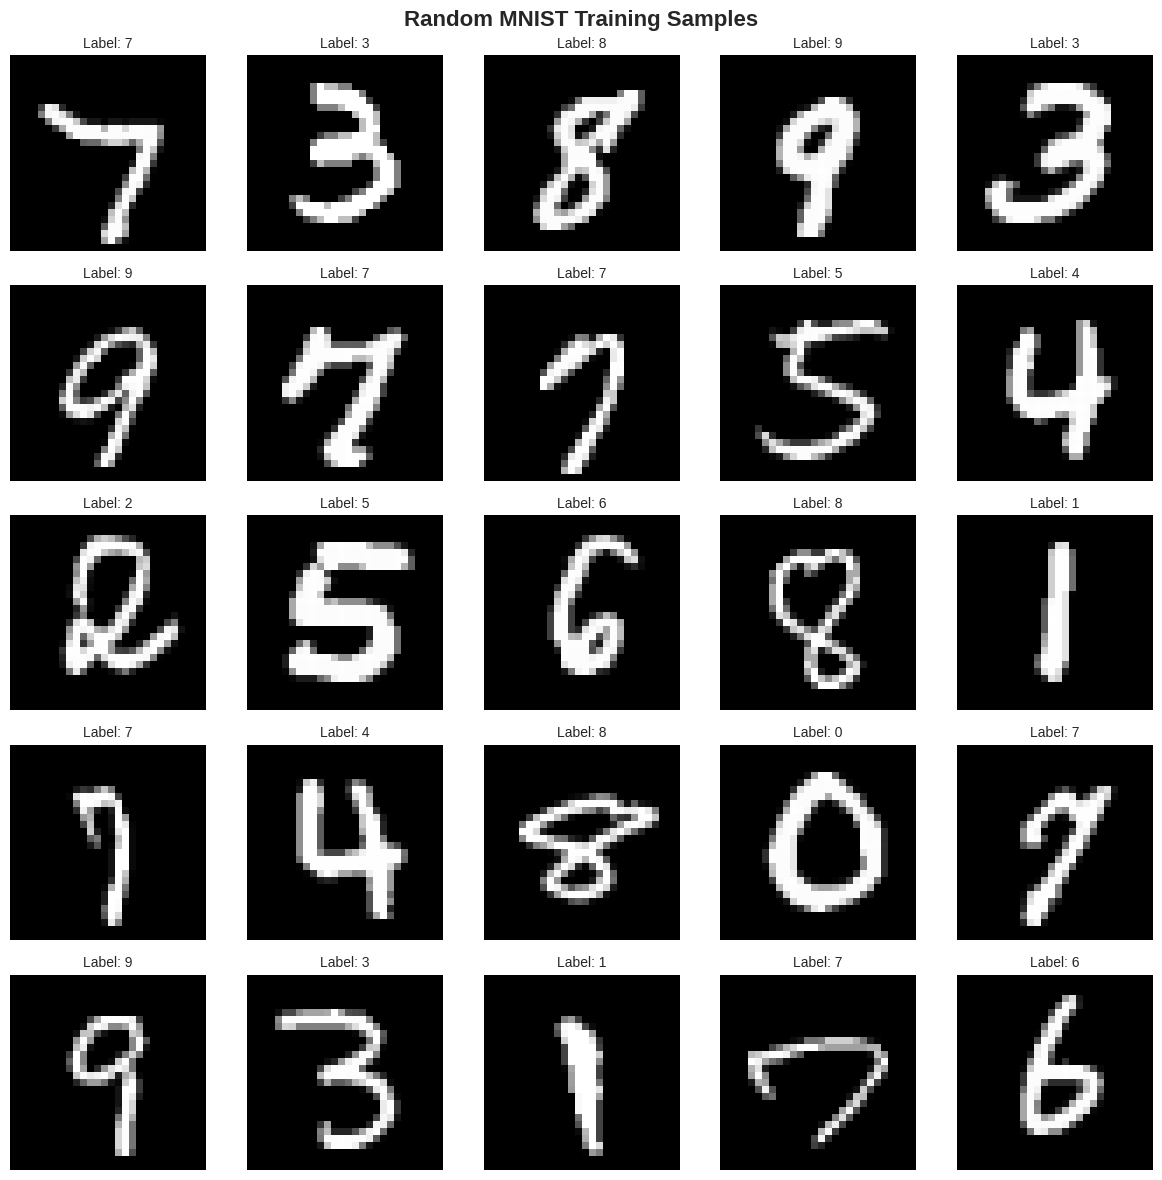

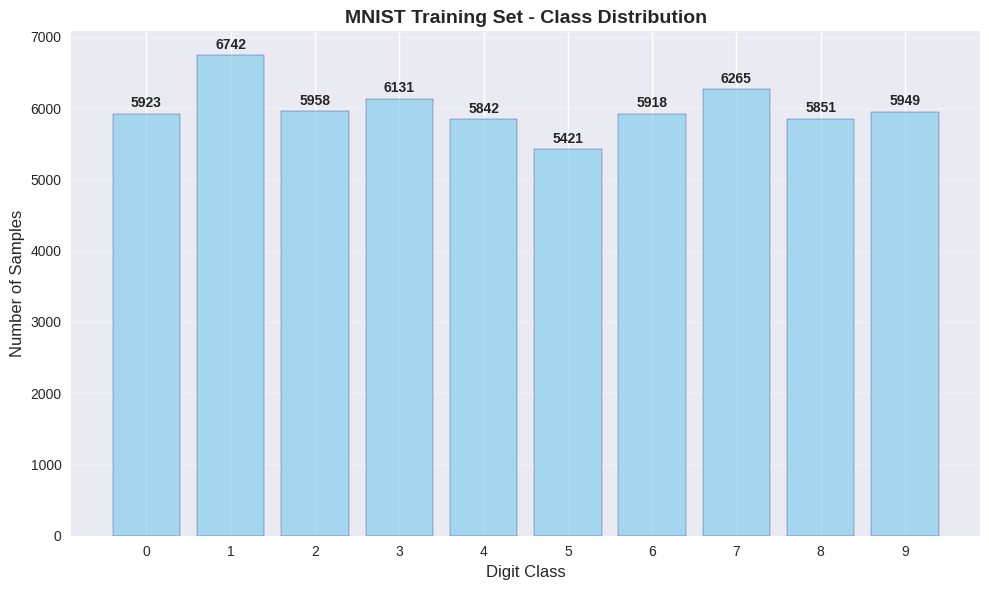

In [4]:
# Data Visualization Functions
def visualize_data_samples(dataset, num_samples=25, title="MNIST Data Samples"):
    """Visualize random samples from the dataset"""

    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Get random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        row, col = i // 5, i % 5
        image, label = dataset[idx]

        # Convert from normalized tensor to displayable image
        image_np = (image.squeeze().numpy() + 1) / 2  # Denormalize from [-1,1] to [0,1]

        axes[row, col].imshow(image_np, cmap='gray')
        axes[row, col].set_title(f'Label: {label}', fontsize=10)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    return fig

def plot_class_distribution(dataset, title="Class Distribution"):
    """Plot the distribution of classes in the dataset"""

    # Count samples per class
    class_counts = torch.zeros(10)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), class_counts.numpy(), alpha=0.7, color='skyblue', edgecolor='navy')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Digit Class', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(range(10))
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, count in zip(bars, class_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{int(count)}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Visualize sample data
print("Data Visualization")
print("=" * 50)

# Show random samples
visualize_data_samples(train_dataset, title="Random MNIST Training Samples")

# Show class distribution
plot_class_distribution(train_dataset, title="MNIST Training Set - Class Distribution")

## Flow Matching Theory & Mathematics

### 1. Setup and Notation

Flow matching learns to transport between two distributions:
- **Prior distribution**: $p_0(x)$ (typically $\mathcal{N}(0, I)$)
- **Data distribution**: $p_1(x)$ (MNIST images)

We define a **coupling** $\pi(x_0, x_1)$ whose marginals are $p_0$ and $p_1$:
$$\int \pi(x_0, x_1) dx_1 = p_0(x_0), \quad \int \pi(x_0, x_1) dx_0 = p_1(x_1)$$

### 2. Interpolation Path & Velocity Field

For a sampled pair $(x_0, x_1) \sim \pi$, we define the **straight-line path**:
$$z(t) = (1-t)x_0 + tx_1, \quad t \in [0,1]$$

The **instantaneous velocity** along this path is:
$$\frac{dz}{dt} = x_1 - x_0$$

The **conditional mean velocity** at location $z$ and time $t$ is:
$$v_t(z) = \mathbb{E}_{(x_0,x_1) \sim \pi}[x_1 - x_0 \mid z(t) = z]$$

### 3. Continuity Equation

The marginal density $p_t(z)$ and velocity field $v_t(z)$ satisfy the **continuity equation**:
$$\boxed{\frac{\partial p_t}{\partial t} + \nabla \cdot (p_t v_t) = 0}$$

This ensures proper transport from $p_0$ to $p_1$.

### 4. Flow Matching Objective

We parameterize a neural network $f_\theta(z, t)$ to approximate $v_t(z)$ by minimizing:
$$\boxed{\mathcal{L}(\theta) = \mathbb{E}_{t \sim \text{Unif}[0,1]} \mathbb{E}_{(x_0,x_1) \sim \pi} \left[ \|f_\theta(z(t), t) - (x_1 - x_0)\|^2 \right]}$$

where $z(t) = (1-t)x_0 + tx_1$.

### 5. Generation Process

After training, we generate samples by solving the **Neural ODE**:
$$\boxed{\frac{dz}{dt} = f_\theta(z, t), \quad z(0) \sim p_0}$$

Integrating from $t=0$ to $t=1$ transforms noise into realistic data samples.

In [5]:
# Neural Network Architecture for Flow Matching (ConvNet)

class TimeEmbedding(nn.Module):
    """Sinusoidal time embedding for conditioning on time t"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

class FiLM(nn.Module):
    """Feature-wise linear modulation from time embedding"""
    def __init__(self, time_dim, channels):
        super().__init__()
        self.to_scale = nn.Linear(time_dim, channels)
        self.to_shift = nn.Linear(time_dim, channels)
    def forward(self, x, t_emb):
        scale = self.to_scale(t_emb)[:, :, None, None]
        shift = self.to_shift(t_emb)[:, :, None, None]
        return x * (1 + scale) + shift

class ConvResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, k=3, dropout=0.1):
        super().__init__()
        pad = k // 2
        self.conv1 = nn.Conv2d(in_ch, out_ch, k, padding=pad)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.film1 = FiLM(time_dim, out_ch)
        self.dropout1 = nn.Dropout2d(dropout)
        self.conv2 = nn.Conv2d(out_ch, out_ch, k, padding=pad)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.film2 = FiLM(time_dim, out_ch)
        self.dropout2 = nn.Dropout2d(dropout)
        self.act = nn.SiLU()
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.film1(h, t_emb)
        h = self.act(h)
        h = self.dropout1(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.film2(h, t_emb)
        h = self.dropout2(h)
        return self.act(h + self.skip(x))

class FlowMatchingConvNet(nn.Module):
    def __init__(self, time_dim=256, base_ch=128, dropout=0.1):
        super().__init__()
        self.time_embed = TimeEmbedding(time_dim)
        self.in_conv = nn.Conv2d(1, base_ch, 3, padding=1)
        self.block1 = ConvResBlock(base_ch, base_ch, time_dim, dropout=dropout)
        # Downsample from 28x28 to 14x14 and increase channels
        self.down = nn.Conv2d(base_ch, base_ch*2, 3, stride=2, padding=1)
        # Now input channels to block2 are base_ch*2
        self.block2 = ConvResBlock(base_ch*2, base_ch*2, time_dim, dropout=dropout)
        self.block3 = ConvResBlock(base_ch*2, base_ch*2, time_dim, dropout=dropout)
        self.block4 = ConvResBlock(base_ch*2, base_ch*4, time_dim, dropout=dropout)
        # Upsample back to 28x28 and reduce channels
        self.up = nn.ConvTranspose2d(base_ch*4, base_ch, 4, stride=2, padding=1)
        self.block5 = ConvResBlock(base_ch, base_ch, time_dim, dropout=dropout)
        self.out_conv = nn.Conv2d(base_ch, 1, 3, padding=1)
        self.act = nn.SiLU()
    def forward(self, x, t):
        t_emb = self.time_embed(t)
        h1 = self.act(self.in_conv(x))            # (B,128,28,28)
        h1 = self.block1(h1, t_emb)
        d  = self.down(h1)                        # (B,256,14,14)
        d  = self.block2(d, t_emb)
        d  = self.block3(d, t_emb)
        d  = self.block4(d, t_emb)                # (B,512,14,14)
        u  = self.up(d)                           # (B,128,28,28)
        u  = self.block5(u, t_emb)
        out = self.out_conv(u)
        return out

# Initialize the model
print("Building ConvNet Flow Matching Model")
model = FlowMatchingConvNet(time_dim=256, base_ch=128, dropout=0.1).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")

# Quick forward test
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)
with torch.no_grad():
    y = model(test_x, test_t)
print("Output shape:", y.shape)

Building ConvNet Flow Matching Model
Model parameters: 9,289,473
Output shape: torch.Size([4, 1, 28, 28])


In [6]:
# Flow Matching Training Functions

class FlowMatchingTrainer:
    """Trainer class for flow matching models"""

    def __init__(self, model, device, learning_rate=1e-4):
        self.model = model
        self.device = device
        self.optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        # Adjust LR based on validation loss
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5)

        # Loss tracking
        self.train_losses = []
        self.val_losses = []
        self.step_losses = []  # Track loss at each step
        self.epoch_boundaries = []  # Track which steps correspond to epoch boundaries

    def sample_coupling(self, x1_batch):
        """
        Sample coupling π(x0, x1) using independent coupling

        Args:
            x1_batch: Batch of real data samples (x1)

        Returns:
            x0_batch: Batch of noise samples (x0)
            x1_batch: Input batch (unchanged)
        """
        # Sample from prior p0 (standard Gaussian)
        x0_batch = torch.randn_like(x1_batch)
        return x0_batch, x1_batch

    def compute_loss(self, x1_batch):
        """
        Compute the flow matching loss for a batch

        Args:
            x1_batch: Batch of real data samples

        Returns:
            loss: Flow matching loss
            info: Dictionary with additional information
        """
        batch_size = x1_batch.shape[0]

        # Sample coupling
        x0_batch, x1_batch = self.sample_coupling(x1_batch)

        # Sample random times
        t = torch.rand(batch_size, device=self.device)

        # Compute interpolated points z(t) = (1-t)x0 + t*x1
        t_expanded = t.view(-1, 1, 1, 1)  # Shape for broadcasting
        z_t = (1 - t_expanded) * x0_batch + t_expanded * x1_batch

        # Compute target velocity (x1 - x0)
        target_velocity = x1_batch - x0_batch

        # Predict velocity with model
        predicted_velocity = self.model(z_t, t)

        # Compute MSE loss
        loss = F.mse_loss(predicted_velocity, target_velocity)

        info = {
            'loss': loss.item(),
            't_mean': t.mean().item(),
            't_std': t.std().item(),
            'velocity_norm': target_velocity.view(batch_size, -1).norm(dim=1).mean().item()
        }

        return loss, info

    def train_step(self, x1_batch):
        """Single training step"""
        self.model.train()
        self.optimizer.zero_grad()

        # Move data to device
        x1_batch = x1_batch.to(self.device)

        # Compute loss
        loss, info = self.compute_loss(x1_batch)

        # Backward pass
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        self.optimizer.step()

        # Track step loss
        self.step_losses.append(info['loss'])

        return info

    def mark_epoch_boundary(self):
        """Mark the current step as an epoch boundary"""
        self.epoch_boundaries.append(len(self.step_losses))

    def validate(self, val_loader, num_batches=10):
        """Validation step with quiet tqdm"""
        self.model.eval()
        val_losses = []
        total = min(num_batches, len(val_loader)) if hasattr(val_loader, '__len__') else num_batches

        with torch.no_grad():
            for i, (x1_batch, _) in enumerate(tqdm(val_loader, total=total, desc='Validating', leave=False, disable=True)):
                if i >= num_batches:
                    break
                x1_batch = x1_batch.to(self.device)
                loss, _ = self.compute_loss(x1_batch)
                val_losses.append(loss.item())

        return np.mean(val_losses) if val_losses else float('nan')

# ODE Solver for Generation

def ode_solver(model, x0, num_steps=50, method='euler'):
    """
    Solve the Neural ODE for generation

    Args:
        model: Trained flow matching model
        x0: Initial noise samples
        num_steps: Number of integration steps
        method: Integration method ('euler' or 'rk4')

    Returns:
        x1: Generated samples
        trajectory: Full trajectory (optional)
    """
    model.eval()

    batch_size = x0.shape[0]
    dt = 1.0 / num_steps

    # Store trajectory
    trajectory = [x0.clone()]
    x = x0.clone()

    with torch.no_grad():
        for i in tqdm(range(num_steps), desc='ODE Solve', leave=False, disable=True):
            t = torch.full((batch_size,), i * dt, device=x.device)

            # Predict velocity
            v = model(x, t)

            if method == 'euler':
                # Euler step: x_{n+1} = x_n + dt * v_n
                x = x + dt * v
            elif method == 'rk4':
                # Runge-Kutta 4th order
                k1 = v
                k2 = model(x + 0.5 * dt * k1, t + 0.5 * dt)
                k3 = model(x + 0.5 * dt * k2, t + 0.5 * dt)
                k4 = model(x + dt * k3, t + dt)

                x = x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

            trajectory.append(x.clone())

    return x, trajectory


 Sample Interpolation Visualization:


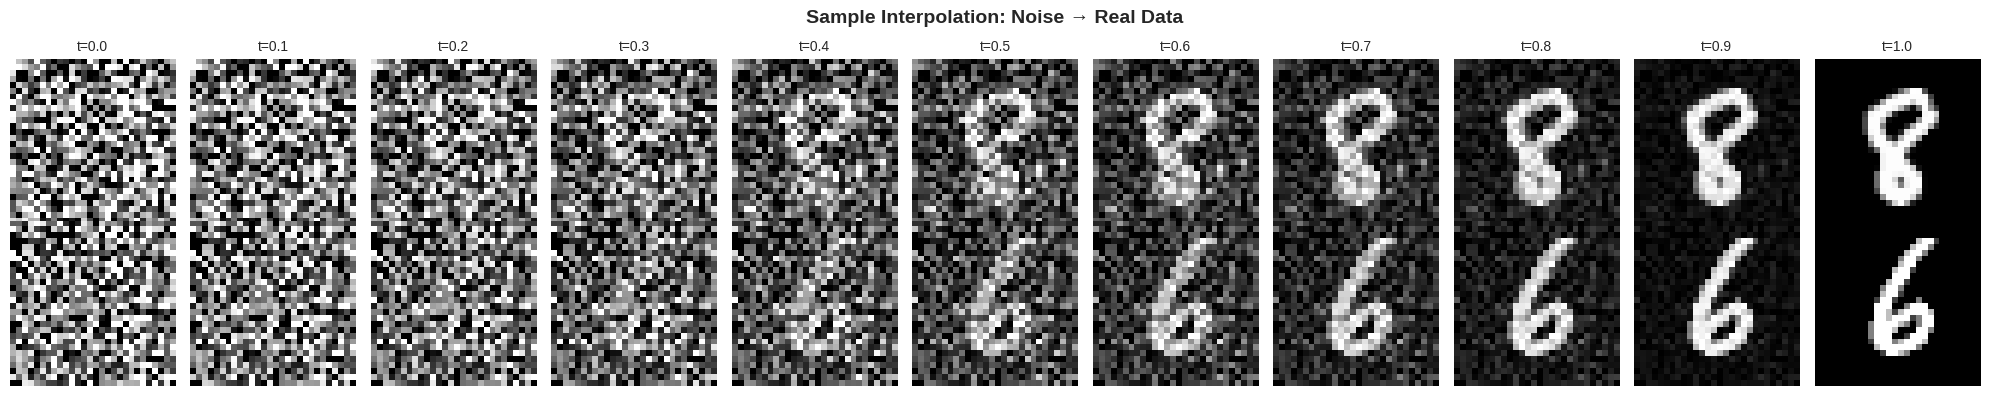

In [7]:
# Visualization Functions for Flow Matching

def visualize_interpolation_path(x0, x1, num_steps=11, title="Flow Matching Interpolation Path"):
    """
    Visualize the straight-line interpolation path z(t) = (1-t)x0 + tx1
    """
    fig, axes = plt.subplots(2, num_steps, figsize=(20, 4))

    for i, t in enumerate(np.linspace(0, 1, num_steps)):
        # Interpolate
        z_t = (1 - t) * x0 + t * x1

        # Plot first sample
        axes[0, i].imshow((z_t[0, 0].cpu() + 1) / 2, cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(f't={t:.1f}', fontsize=10)
        axes[0, i].axis('off')

        # Plot second sample
        axes[1, i].imshow((z_t[1, 0].cpu() + 1) / 2, cmap='gray', vmin=0, vmax=1)
        axes[1, i].axis('off')

    # Add labels
    axes[0, 0].set_ylabel('Sample 1', fontsize=12, rotation=90, labelpad=20)
    axes[1, 0].set_ylabel('Sample 2', fontsize=12, rotation=90, labelpad=20)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_generation_trajectory(trajectory, num_samples=4, num_steps_show=11):
    """
    Visualize the generation trajectory from noise to data
    """
    num_total_steps = len(trajectory)
    step_indices = np.linspace(0, num_total_steps-1, num_steps_show, dtype=int)

    fig, axes = plt.subplots(num_samples, num_steps_show, figsize=(20, 8))

    for j, step_idx in enumerate(step_indices):
        t = step_idx / (num_total_steps - 1)

        for i in range(num_samples):
            img = trajectory[step_idx][i, 0].cpu()
            img = (img + 1) / 2  # Denormalize

            axes[i, j].imshow(img, cmap='gray', vmin=0, vmax=1)
            if i == 0:
                axes[i, j].set_title(f't={t:.2f}', fontsize=10)
            axes[i, j].axis('off')

    # Add row labels
    for i in range(num_samples):
        axes[i, 0].set_ylabel(f'Sample {i+1}', fontsize=10, rotation=90, labelpad=20)

    plt.suptitle('Flow Matching Generation Trajectory: Noise → Data', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def _compute_limits(train_losses, val_losses):
    vals = []
    if train_losses:
        vals.extend([v for v in train_losses if np.isfinite(v)])
    if val_losses:
        vals.extend([v for v in val_losses if np.isfinite(v)])
    if not vals:
        return None
    lo, hi = float(np.min(vals)), float(np.max(vals))
    if lo == hi:
        hi = lo * 1.05 + (1e-8 if lo == 0 else 0)
    pad = 0.05 * (hi - lo) if hi > lo else 0.1
    return max(0.0, lo - pad), hi + pad

def plot_training_progress_with_steps(trainer, title="Training Progress"):
    """Plot training progress showing step-by-step losses with epoch boundaries"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot 1: Step-by-step loss with epoch boundaries (log scale)
    if trainer.step_losses:
        steps = range(1, len(trainer.step_losses) + 1)
        ax1.semilogy(steps, trainer.step_losses, alpha=0.7, linewidth=0.8, color='blue', label='Step Loss')

        # Add vertical lines for epoch boundaries
        for i, boundary in enumerate(trainer.epoch_boundaries):
            if boundary <= len(trainer.step_losses):
                ax1.axvline(x=boundary, color='red', linestyle='--', alpha=0.7, linewidth=1)
                ax1.text(boundary, ax1.get_ylim()[1]*0.9, f'E{i+1}', rotation=90,
                        verticalalignment='top', fontsize=8, color='red')

        ax1.set_xlabel('Training Step')
        ax1.set_ylabel('Loss (log scale)')
        ax1.set_title('Step-by-Step Training Loss with Epoch Boundaries')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # Set sensible y limits for log plot
        step_vals = [max(1e-8, v) for v in trainer.step_losses if np.isfinite(v)]
        if step_vals:
            lo, hi = min(step_vals), max(step_vals)
            ax1.set_ylim(lo * 0.5, hi * 2)

    # Plot 2: Epoch-level loss comparison
    if trainer.train_losses:
        epochs = range(1, len(trainer.train_losses) + 1)
        ax2.plot(epochs, trainer.train_losses, label='Training Loss', alpha=0.8, marker='o', markersize=4)

        if trainer.val_losses and len(trainer.val_losses) > 0:
            # Align validation points at epoch intervals
            val_epochs = np.linspace(1, len(trainer.train_losses), num=len(trainer.val_losses))
            ax2.plot(val_epochs, trainer.val_losses, label='Validation Loss', alpha=0.8, marker='s', markersize=4)

        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Epoch-Level Training Progress')
        ax2.legend()
        ax2.grid(alpha=0.3)

        # Set sensible y limits
        lims = _compute_limits(trainer.train_losses, trainer.val_losses)
        if lims:
            ax2.set_ylim(*lims)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_training_progress(train_losses, val_losses=None, title="Training Progress"):
    """Plot training and validation losses with sensible y-limits"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(train_losses) + 1)

    # Loss plot (linear)
    ax1.plot(epochs, train_losses, label='Training Loss', alpha=0.8)
    if val_losses is not None and len(val_losses) > 0:
        # align val points at multiples of val_interval if possible
        x_val = np.linspace(3, len(train_losses), num=len(val_losses)) if len(train_losses) != len(val_losses) else epochs
        ax1.plot(x_val, val_losses, label='Validation Loss', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)
    lims = _compute_limits(train_losses, val_losses)
    if lims:
        ax1.set_ylim(*lims)

    # Log-scale plot
    ax2.semilogy(epochs, train_losses, label='Training Loss', alpha=0.8)
    if val_losses is not None and len(val_losses) > 0:
        x_val = np.linspace(3, len(train_losses), num=len(val_losses)) if len(train_losses) != len(val_losses) else epochs
        ax2.semilogy(x_val, val_losses, label='Validation Loss', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss (log scale)')
    ax2.set_title('Training Loss (Log Scale)')
    ax2.legend()
    ax2.grid(alpha=0.3)
    # Ensure positive lower bound for log plot
    log_lims = _compute_limits([max(1e-8, v) for v in train_losses], [max(1e-8, v) for v in (val_losses or [])])
    if log_lims:
        ax2.set_ylim(*log_lims)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create sample interpolation visualization
with torch.no_grad():
    # Get some real samples
    sample_batch, _ = next(iter(train_loader))
    sample_batch = sample_batch[:2].to(device)

    # Generate noise samples
    noise_samples = torch.randn_like(sample_batch)

    print("\n Sample Interpolation Visualization:")
    visualize_interpolation_path(noise_samples, sample_batch, title="Sample Interpolation: Noise → Real Data")

In [8]:
# ===== PCA utilities and projections =====

def pca_fit(X, k=3):
    """
    Fit PCA using SVD (no sklearn).
    X: (N, D) zero-centered data
    Returns: mean (D,), components (k, D), explained_var (k,), explained_var_ratio (k,)
    """
    X = X.astype(np.float32)
    mean = X.mean(axis=0)
    Xc = X - mean
    # Economy SVD
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    components = Vt[:k]
    # explained variance of each PC
    n = X.shape[0]
    explained_var = (S[:k] ** 2) / (n - 1)
    total_var = (S ** 2).sum() / (n - 1)
    explained_var_ratio = explained_var / (total_var + 1e-12)
    return mean, components, explained_var, explained_var_ratio


def pca_transform(X, mean, components):
    """Project X onto PCA components."""
    return (X - mean) @ components.T


def compute_class_stats(Z, y):
    """
    Compute per-class centroid and covariance in Z-space (PCA space).
    Z: (N, K), y: (N,)
    Returns dict with 'mu' (10,K), 'cov' (10,K,K), 'counts'(10)
    """
    K = Z.shape[1]
    stats = {
        'mu': np.zeros((10, K), dtype=np.float32),
        'cov': np.zeros((10, K, K), dtype=np.float32),
        'counts': np.zeros(10, dtype=np.int32)
    }
    for c in range(10):
        idx = (y == c)
        stats['counts'][c] = int(idx.sum())
        if stats['counts'][c] > 1:
            Zc = Z[idx]
            mu = Zc.mean(axis=0)
            Xm = Zc - mu
            cov = (Xm.T @ Xm) / (len(Zc) - 1)
            stats['mu'][c] = mu
            stats['cov'][c] = cov
        elif stats['counts'][c] == 1:
            stats['mu'][c] = Z[idx][0]
            stats['cov'][c] = np.eye(K, dtype=np.float32) * 1e-3
        else:
            stats['mu'][c] = np.zeros(K, dtype=np.float32)
            stats['cov'][c] = np.eye(K, dtype=np.float32)
    return stats


def gaussian_pdf(x, mu, cov):
    """Compute multivariate Gaussian pdf for a batch of points x (N,K)."""
    K = x.shape[1]
    cov = cov + np.eye(K) * 1e-6
    try:
        L = np.linalg.cholesky(cov)
        Linv = np.linalg.inv(L)
        diff = (x - mu)
        maha = np.sum((Linv @ diff.T) ** 2, axis=0)
        log_det = 2.0 * np.sum(np.log(np.diag(L)))
    except np.linalg.LinAlgError:
        inv = np.linalg.pinv(cov)
        diff = (x - mu)
        maha = np.sum(diff @ inv * diff, axis=1)
        log_det = -np.log(np.linalg.det(inv) + 1e-12)
    log_norm = -0.5 * (K * np.log(2*np.pi) + log_det)
    return np.exp(log_norm - 0.5 * maha)


def assign_classes_by_gaussian(Z, stats):
    """Assign class by highest Gaussian likelihood under per-class stats."""
    N = Z.shape[0]
    K = Z.shape[1]
    ll = np.zeros((N, 10), dtype=np.float32)
    for c in range(10):
        mu = stats['mu'][c]
        cov = stats['cov'][c]
        ll[:, c] = gaussian_pdf(Z, mu, cov)
    y_pred = np.argmax(ll, axis=1)
    return y_pred, ll


def fit_pca_on_dataset(dataset, max_samples=20000, k=3):
    """Sample dataset with labels, flatten, fit PCA, and compute stats."""
    imgs, labels = [], []
    n = min(max_samples, len(dataset))
    rng = np.random.default_rng(42)
    idxs = rng.choice(len(dataset), size=n, replace=False)
    for i in idxs:
        x, y = dataset[i]
        imgs.append(x.view(-1).numpy())
        labels.append(int(y))
    X = np.stack(imgs, axis=0)
    y = np.array(labels, dtype=np.int32)
    mean, comps, ev, evr = pca_fit(X, k=k)
    Z = pca_transform(X, mean, comps)
    stats = compute_class_stats(Z, y)
    return {
        'mean': mean,
        'components': comps,
        'explained_var': ev,
        'explained_var_ratio': evr,
        'Z': Z,
        'y': y,
        'stats': stats
    }


def project_generated(model, num=2000, steps=60, method='rk4', mean=None, components=None):
    """Generate samples, flatten, and project via provided PCA transform."""
    model.eval()
    with torch.no_grad():
        x0 = torch.randn(num, 1, 28, 28, device=device)
        xg, _ = ode_solver(model, x0, num_steps=steps, method=method)
        Xg = xg.detach().cpu().view(num, -1).numpy()
    Zg = pca_transform(Xg, mean, components)
    return Zg


def plot_pca_2d(Z, y, Zg=None, title="PCA (2D) Real vs Generated"):
    plt.figure(figsize=(9, 7))
    # Real data
    scatter = plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap='tab10', s=8, alpha=0.25, label='Real')
    handles, _ = scatter.legend_elements()
    # Generated overlay
    if Zg is not None:
        plt.scatter(Zg[:, 0], Zg[:, 1], c='k', s=10, alpha=0.3, label='Generated')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


def plot_pca_3d(Z, y, Zg=None, title="PCA (3D) Real vs Generated"):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Real
    p = ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=y, cmap='tab10', s=8, alpha=0.25)
    # Generated
    if Zg is not None:
        ax.scatter(Zg[:, 0], Zg[:, 1], Zg[:, 2], c='k', s=10, alpha=0.3)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_class_gaussians_2d(stats, comps_names=('PC1','PC2')):
    """Plot 1-sigma Gaussian ellipses for classes in 2D (PC1-PC2)."""
    from matplotlib.patches import Ellipse
    fig, ax = plt.subplots(figsize=(8, 7))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    for c in range(10):
        mu = stats['mu'][c][:2]
        cov = stats['cov'][c][:2, :2]
        # Eigen-decomposition for ellipse
        vals, vecs = np.linalg.eigh(cov + np.eye(2)*1e-6)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
        width, height = 2*np.sqrt(vals)
        ell = Ellipse(xy=mu, width=width, height=height, angle=angle,
                      edgecolor=colors[c], facecolor='none', lw=2, label=f'{c}')
        ax.add_patch(ell)
        ax.scatter(*mu, color=colors[c], s=30)
    ax.set_xlabel(comps_names[0])
    ax.set_ylabel(comps_names[1])
    ax.set_title('Per-class 1-sigma ellipses in PCA space')
    ax.legend(title='Digit', ncols=5)
    ax.grid(alpha=0.3)
    plt.show()


def plot_probs_and_hist(y_true, y_pred, ll):
    """Plot predicted class distribution and average likelihoods."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Pred class histogram
    axes[0].hist(y_pred, bins=np.arange(11)-0.5, rwidth=0.8, color='gray')
    axes[0].set_xticks(range(10))
    axes[0].set_title('Generated class counts (by Gaussian assignment)')
    axes[0].set_xlabel('Digit')
    axes[0].set_ylabel('Count')
    # Likelihoods per class
    avg_ll = ll.mean(axis=0)
    axes[1].bar(range(10), avg_ll, color='skyblue', edgecolor='navy')
    axes[1].set_xticks(range(10))
    axes[1].set_title('Avg Gaussian probability per class')
    axes[1].set_xlabel('Digit')
    axes[1].set_ylabel('Probability (unnormalized)')
    plt.tight_layout()
    plt.show()

In [9]:
# Utility: compare real vs generated samples

def compare_real_vs_generated(real_batch, gen_batch, num_samples=10):
    num = min(num_samples, real_batch.size(0), gen_batch.size(0))
    fig, axes = plt.subplots(2, num, figsize=(1.6*num, 3.2))
    for i in range(num):
        real = (real_batch[i, 0].detach().cpu() + 1) / 2
        gen = (gen_batch[i, 0].detach().cpu() + 1) / 2
        axes[0, i].imshow(real, cmap='gray', vmin=0, vmax=1)
        axes[0, i].axis('off')
        axes[1, i].imshow(gen, cmap='gray', vmin=0, vmax=1)
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel('Real', fontsize=10)
    axes[1, 0].set_ylabel('Gen', fontsize=10)
    plt.suptitle('Real vs Generated', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

🎯 Starting Flow Matching Training
Epochs: 50
Learning Rate: 5.00e-04
Batch Size: 1024
Training Samples: 60000


Epoch 1/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 1/50 | Train: 0.9952 | Val: 0.4003 | LR: 5.00e-04


Epoch 2/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2/50 | Train: 0.3326 | Val: 0.2634 | LR: 5.00e-04


Epoch 3/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 4/50 | Train: 0.2344 | Val: 0.2141 | LR: 5.00e-04


Epoch 5/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 6/50 | Train: 0.2159 | Val: 0.2010 | LR: 5.00e-04


Epoch 7/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 8/50 | Train: 0.2061 | Val: 0.1944 | LR: 5.00e-04


Epoch 9/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 10/50 | Train: 0.2002 | Val: 0.1916 | LR: 5.00e-04


Epoch 11/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 12/50 | Train: 0.1963 | Val: 0.1895 | LR: 5.00e-04


Epoch 13/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 14/50 | Train: 0.1937 | Val: 0.1854 | LR: 5.00e-04


Epoch 15/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 16/50 | Train: 0.1908 | Val: 0.1842 | LR: 5.00e-04


Epoch 17/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 18/50 | Train: 0.1886 | Val: 0.1824 | LR: 5.00e-04


Epoch 19/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 20/50 | Train: 0.1881 | Val: 0.1803 | LR: 5.00e-04


Epoch 21/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 22/50 | Train: 0.1863 | Val: 0.1810 | LR: 5.00e-04


Epoch 23/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 24/50 | Train: 0.1861 | Val: 0.1785 | LR: 5.00e-04


Epoch 25/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 26/50 | Train: 0.1836 | Val: 0.1787 | LR: 5.00e-04


Epoch 27/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 28/50 | Train: 0.1829 | Val: 0.1806 | LR: 5.00e-04


Epoch 29/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 30/50 | Train: 0.1818 | Val: 0.1758 | LR: 5.00e-04


Epoch 31/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 32/50 | Train: 0.1811 | Val: 0.1776 | LR: 5.00e-04


Epoch 33/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 34/50 | Train: 0.1809 | Val: 0.1754 | LR: 5.00e-04


Epoch 35/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 36/50 | Train: 0.1798 | Val: 0.1756 | LR: 5.00e-04


Epoch 37/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 38/50 | Train: 0.1792 | Val: 0.1729 | LR: 5.00e-04


Epoch 39/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 40/50 | Train: 0.1780 | Val: 0.1732 | LR: 5.00e-04


Epoch 41/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 42/50 | Train: 0.1780 | Val: 0.1748 | LR: 5.00e-04


Epoch 43/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 44/50 | Train: 0.1775 | Val: 0.1719 | LR: 5.00e-04


Epoch 45/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 46/50 | Train: 0.1770 | Val: 0.1728 | LR: 5.00e-04


Epoch 47/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 48/50 | Train: 0.1773 | Val: 0.1743 | LR: 5.00e-04


Epoch 49/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 50/50 | Train: 0.1762 | Val: 0.1712 | LR: 5.00e-04
✅ Training completed!


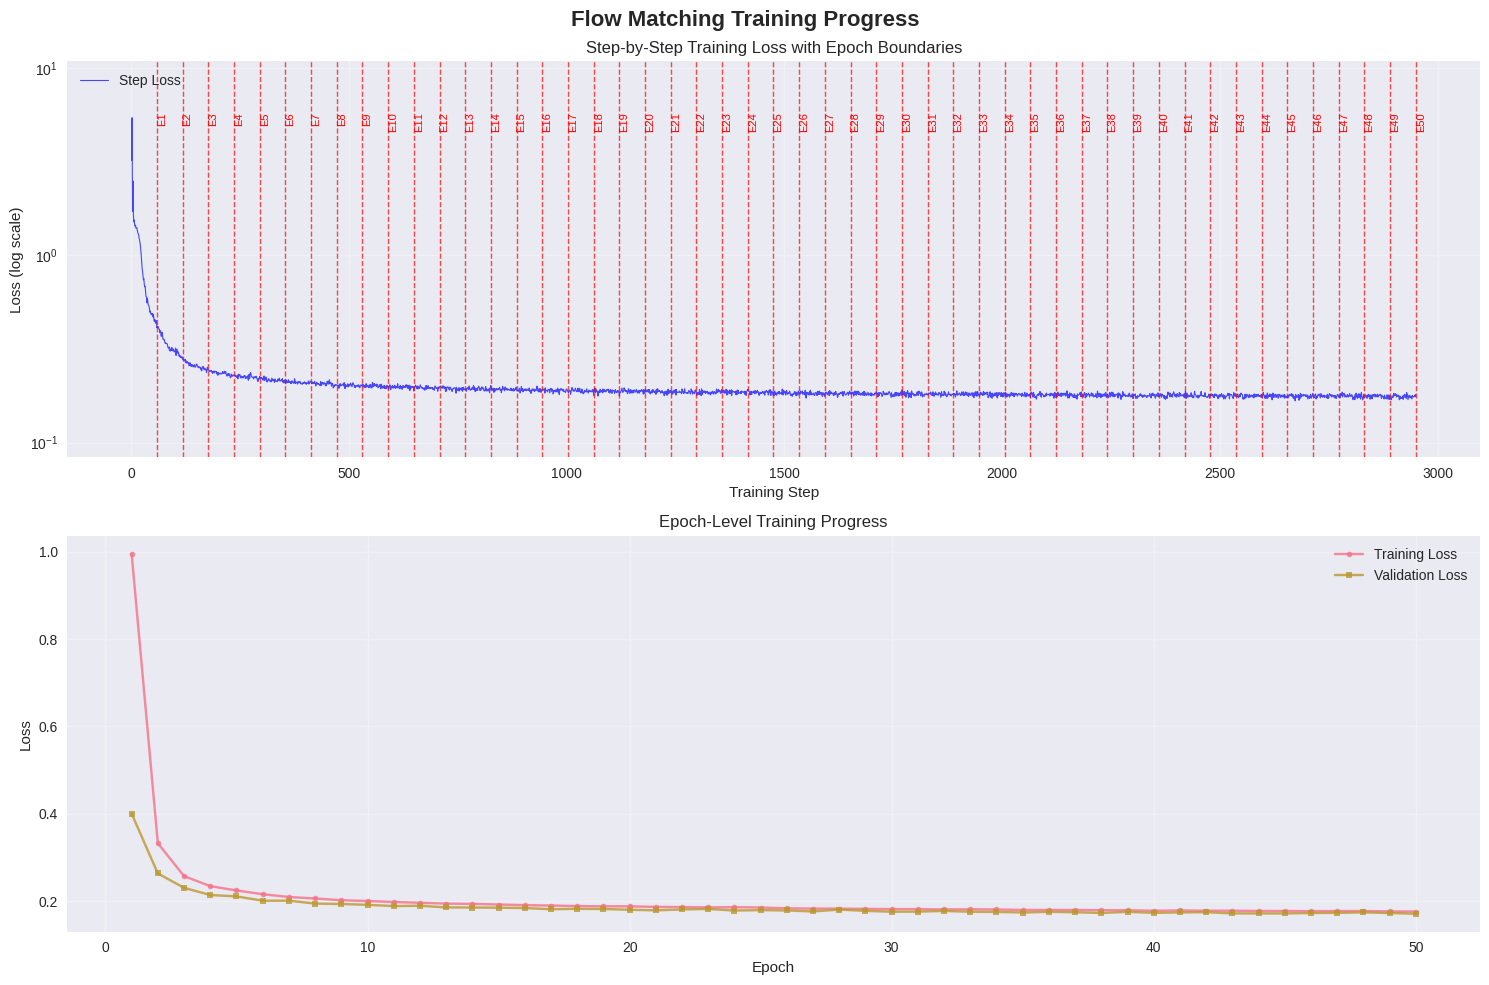

In [10]:
# Training the Flow Matching Model

# Initialize trainer (safe re-init if missing)

trainer = FlowMatchingTrainer(model, device, learning_rate=5e-4)

# Training hyperparameters (increased)
num_epochs = 50
print_interval = 2
val_interval = 1

print("🎯 Starting Flow Matching Training")
print("=" * 50)
print(f"Epochs: {num_epochs}")
print(f"Learning Rate: {trainer.optimizer.param_groups[0]['lr']:.2e}")
print(f"Batch Size: {train_loader.batch_size}")
print(f"Training Samples: {len(train_dataset)}")
print("=" * 50)

# Training loop (single tqdm) with graceful interrupt
ckpt_path = "flow_checkpoint.pt"
interrupted = False

try:
    for epoch in range(1, num_epochs + 1):
        model.train()
        batch_losses = []

        with tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=True, dynamic_ncols=True) as pbar:
            for x_batch, _ in pbar:
                info = trainer.train_step(x_batch)
                batch_losses.append(info['loss'])

        # Mark epoch boundary for step plotting
        trainer.mark_epoch_boundary()

        # Aggregate epoch loss
        epoch_loss = float(np.mean(batch_losses)) if batch_losses else float('nan')
        trainer.train_losses.append(epoch_loss)

        # Validation (quiet)
        val_loss = None
        if (epoch % val_interval) == 0:
            val_loss = float(trainer.validate(test_loader, num_batches=20))
            trainer.val_losses.append(val_loss)
            trainer.scheduler.step(val_loss)

        # Epoch summary
        val_str = f"{val_loss:.4f}" if val_loss is not None else '—'
        if (epoch % print_interval) == 0 or epoch == 1:
            print(f"Epoch {epoch}/{num_epochs} | Train: {epoch_loss:.4f} | Val: {val_str} | LR: {trainer.optimizer.param_groups[0]['lr']:.2e}")
except KeyboardInterrupt:
    interrupted = True
    # Save checkpoint on interrupt
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': trainer.optimizer.state_dict(),
        'scheduler_state_dict': trainer.scheduler.state_dict(),
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'step_losses': trainer.step_losses,
        'epoch_boundaries': trainer.epoch_boundaries,
        'epoch': epoch,
    }
    torch.save(state, ckpt_path)
    print(f"\n⏹️ Training interrupted at epoch {epoch}. Checkpoint saved to {ckpt_path}.")

if not interrupted:
    print("✅ Training completed!")

# Plot training progress with step-by-step view
plot_training_progress_with_steps(trainer, title="Flow Matching Training Progress")

In [11]:
# Optional: Resume from checkpoint utility
import os

def load_checkpoint(path="flow_checkpoint.pt"):
    if os.path.exists(path):
        state = torch.load(path, map_location=device)
        model.load_state_dict(state['model_state_dict'])
        trainer.optimizer.load_state_dict(state['optimizer_state_dict'])
        trainer.scheduler.load_state_dict(state['scheduler_state_dict'])
        trainer.train_losses = state.get('train_losses', trainer.train_losses)
        trainer.val_losses = state.get('val_losses', trainer.val_losses)
        trainer.step_losses = state.get('step_losses', trainer.step_losses)
        trainer.epoch_boundaries = state.get('epoch_boundaries', trainer.epoch_boundaries)
        start_epoch = int(state.get('epoch', 0)) + 1
        print(f"Loaded checkpoint from {path} (resume at epoch {start_epoch}).")
        return start_epoch
    else:
        print("No checkpoint found; starting fresh.")
        return 1

Generating samples using the trained flow...


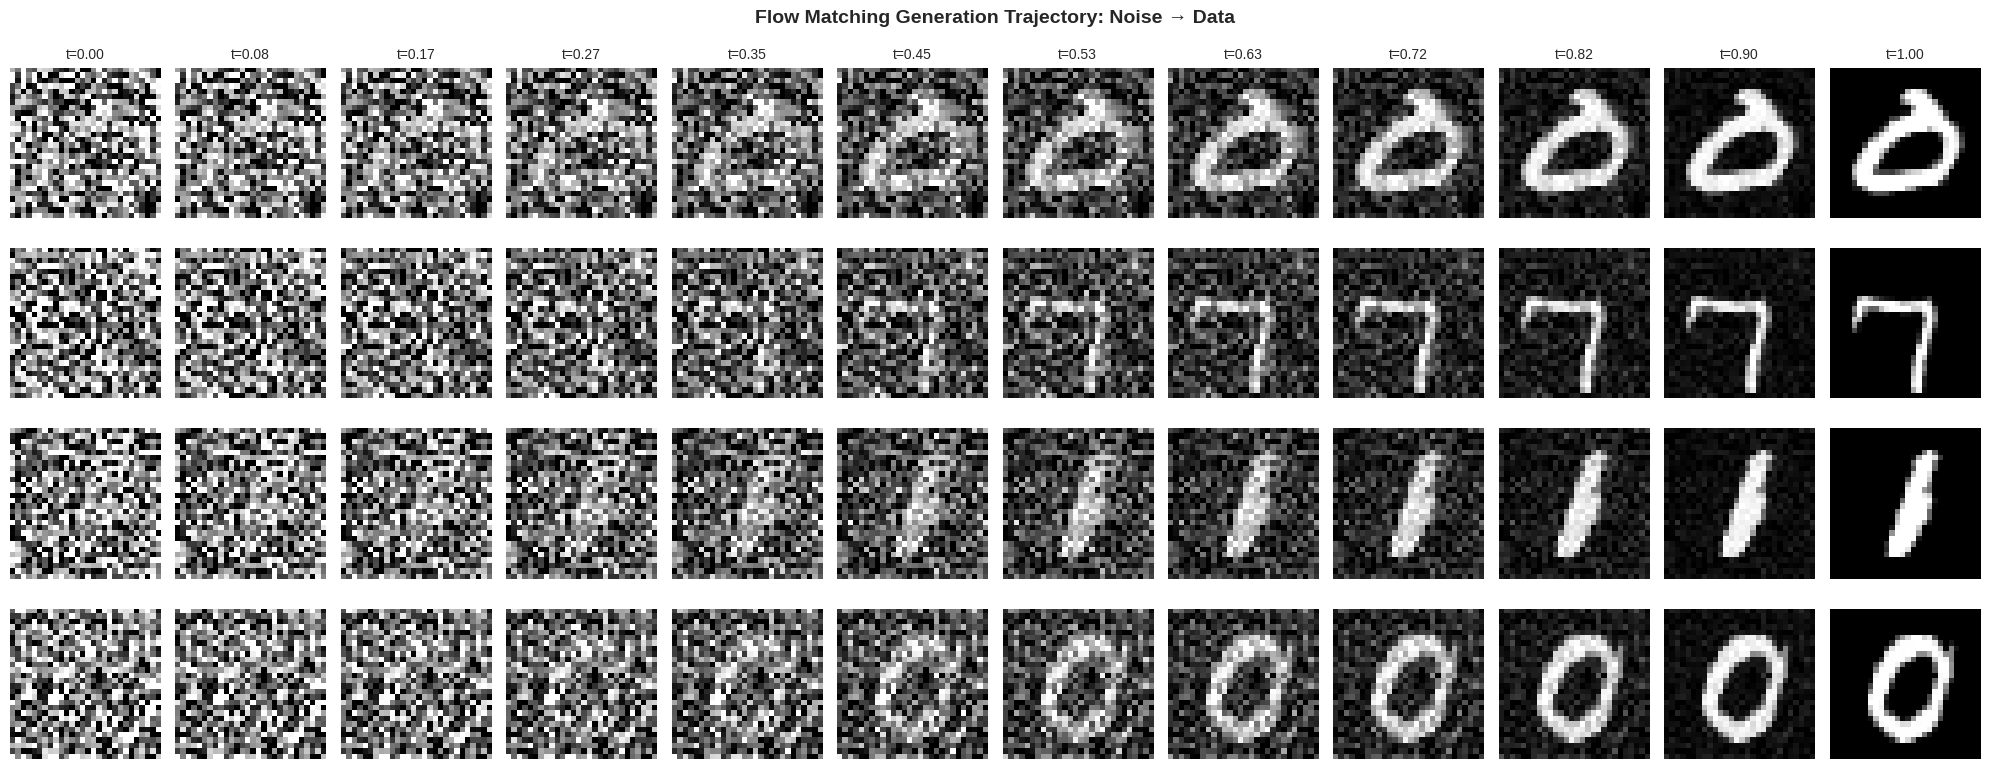

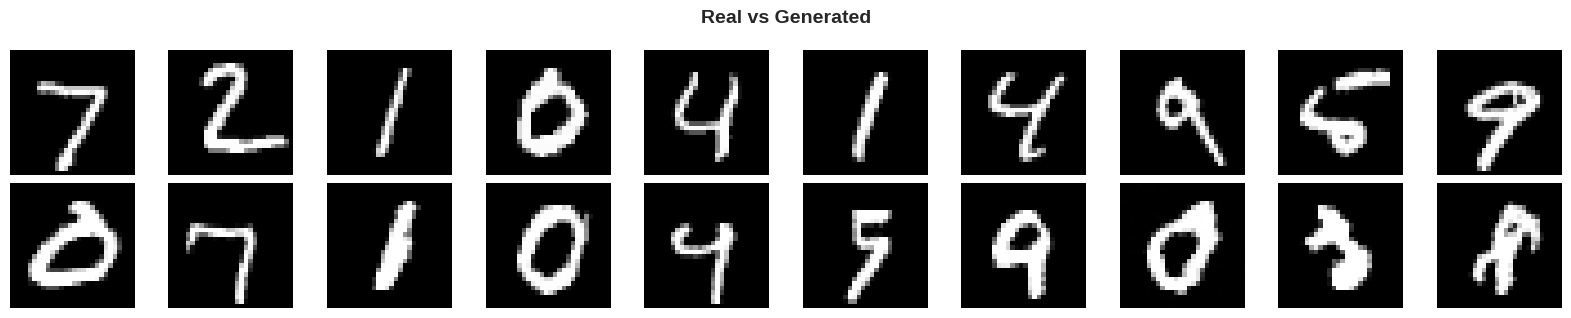

In [12]:
# Generation and Visualization

print("Generating samples using the trained flow...")

# Sample initial noise
num_generate = 32
x0 = torch.randn(num_generate, 1, 28, 28).to(device)

# Solve ODE to generate samples
x1_generated, trajectory = ode_solver(model, x0, num_steps=60, method='rk4')

# Fetch some real samples for comparison
real_batch, _ = next(iter(test_loader))
real_batch = real_batch[:num_generate].to(device)

# Visualize generation trajectory for a few samples
visualize_generation_trajectory(trajectory, num_samples=4, num_steps_show=12)

# Compare real vs generated samples
compare_real_vs_generated(real_batch[:10], x1_generated[:10], num_samples=10)

Generating samples with diverse starting distributions...
Generating from Standard Gaussian...
Generating from Scaled Gaussian (σ=2)...
Generating from Uniform [-1,1]...
Generating from Ring Distribution...
Generating from Corner Biased...
Generating from Center Spike...


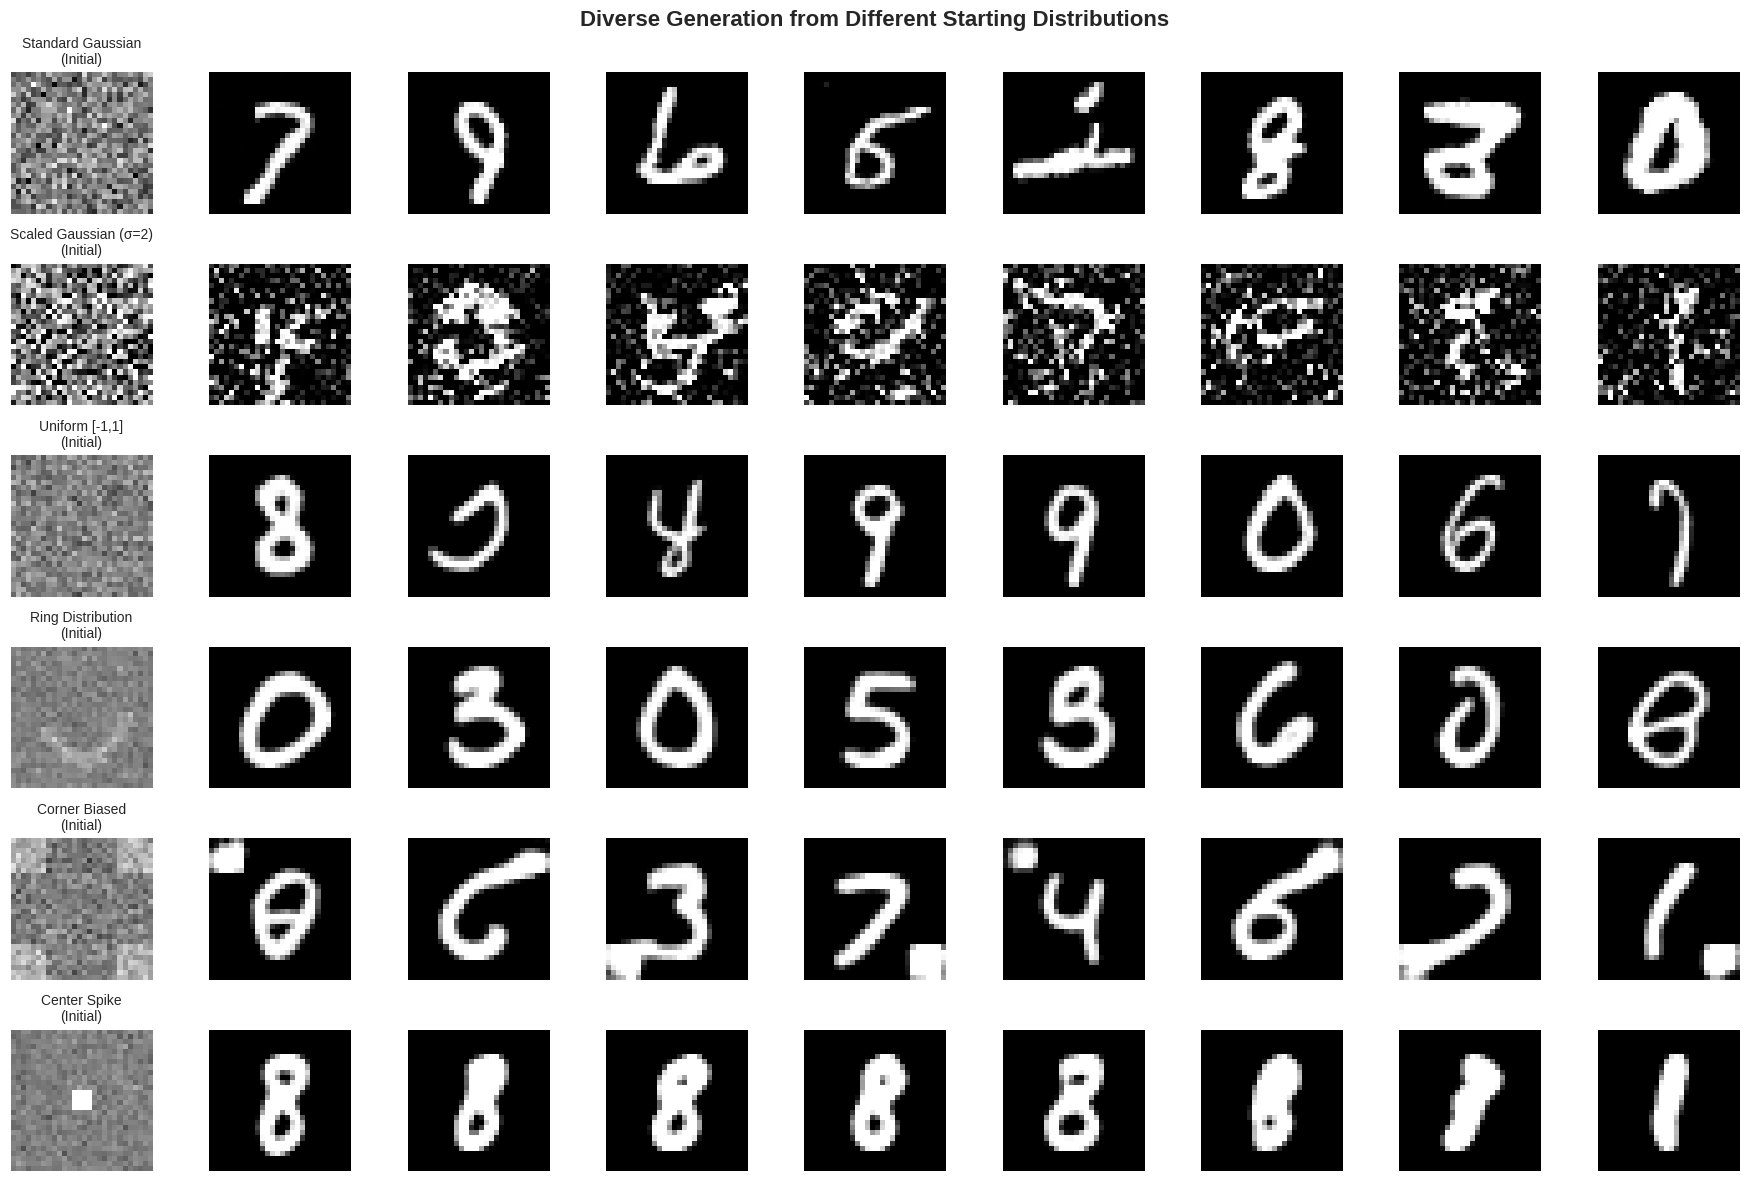


Generation Quality Analysis
Standard Gaussian:
  Mean intensity: -0.703
  Std intensity:  0.671
  Range: [-1.055, 1.059]

Scaled Gaussian (σ=2):
  Mean intensity: -0.736
  Std intensity:  0.909
  Range: [-2.916, 2.948]

Uniform [-1,1]:
  Mean intensity: -0.816
  Std intensity:  0.562
  Range: [-1.068, 1.037]

Ring Distribution:
  Mean intensity: -0.700
  Std intensity:  0.688
  Range: [-1.060, 1.035]

Corner Biased:
  Mean intensity: -0.645
  Std intensity:  0.730
  Range: [-1.052, 1.160]

Center Spike:
  Mean intensity: -0.697
  Std intensity:  0.741
  Range: [-1.067, 1.367]

Testing model robustness with extreme inputs...


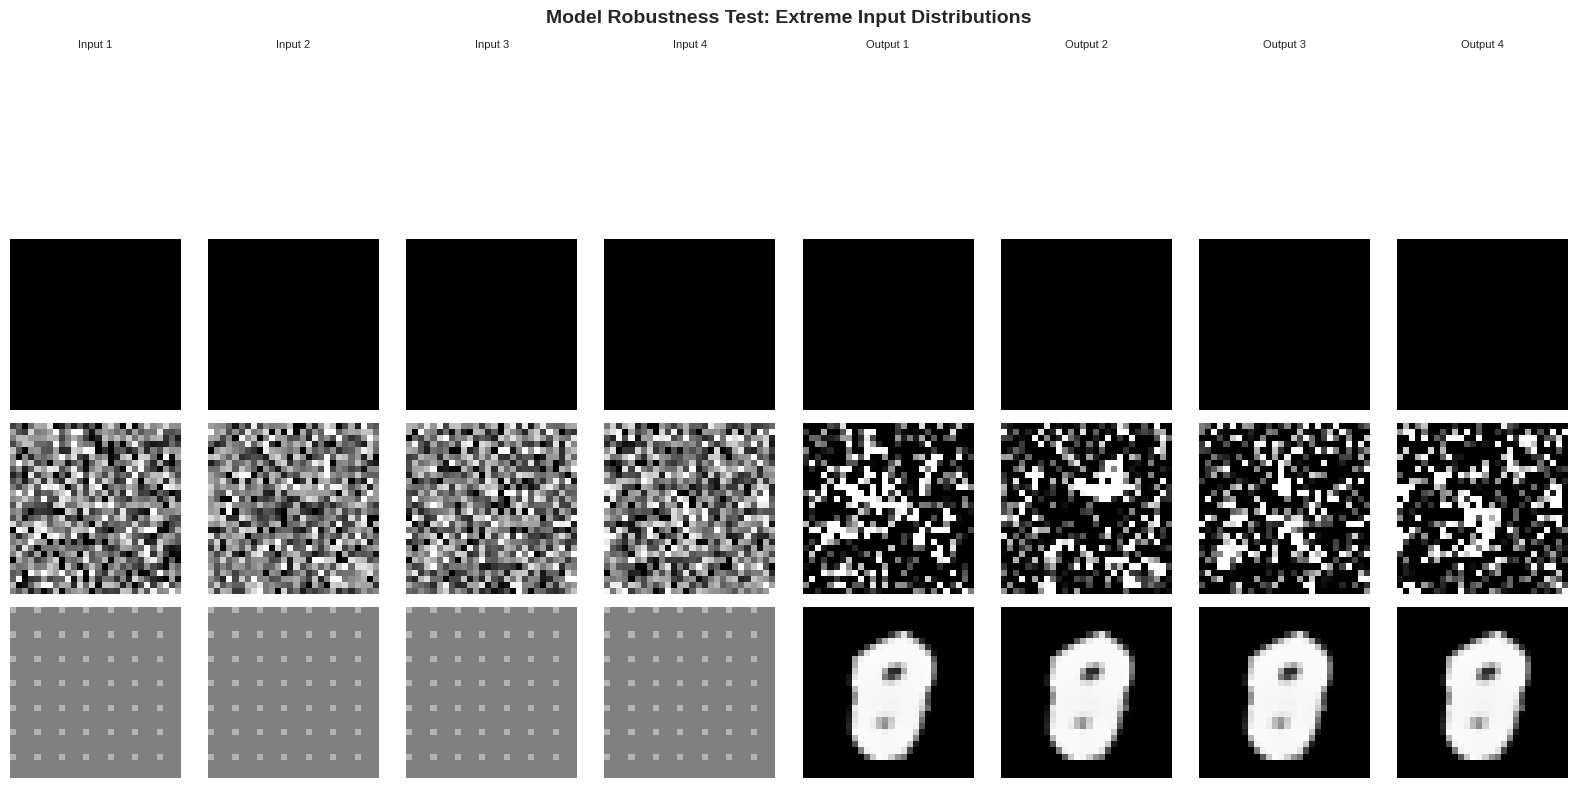

In [13]:

print("Generating samples with diverse starting distributions...")

def generate_diverse_samples(model, num_samples=16, num_steps=60, method='rk4'):
    """Generate samples from various starting distributions"""
    model.eval()

    # Different starting distributions
    distributions = {
        'Standard Gaussian': torch.randn(num_samples, 1, 28, 28),
        'Scaled Gaussian (σ=2)': torch.randn(num_samples, 1, 28, 28) * 2.0,
        'Uniform [-1,1]': torch.rand(num_samples, 1, 28, 28) * 2 - 1,
        'Ring Distribution': create_ring_distribution(num_samples),
        'Corner Biased': create_corner_biased(num_samples),
        'Center Spike': create_center_spike(num_samples)
    }

    results = {}

    for name, x0 in distributions.items():
        print(f"Generating from {name}...")
        x0 = x0.to(device)

        with torch.no_grad():
            x1_gen, trajectory = ode_solver(model, x0, num_steps=num_steps, method=method)

        results[name] = {
            'generated': x1_gen,
            'trajectory': trajectory,
            'initial': x0
        }

    return results

def create_ring_distribution(num_samples):
    """Create samples in a ring around the center"""
    x0 = torch.randn(num_samples, 1, 28, 28) * 0.3  # Small noise
    # Add ring pattern in center
    center_y, center_x = 14, 14
    radius = 8
    for i in range(num_samples):
        angle = 2 * np.pi * i / num_samples
        y_offset = int(radius * np.sin(angle))
        x_offset = int(radius * np.cos(angle))
        y_pos = max(0, min(27, center_y + y_offset))
        x_pos = max(0, min(27, center_x + x_offset))
        x0[i, 0, y_pos-1:y_pos+2, x_pos-1:x_pos+2] += 2.0
    return x0

def create_corner_biased(num_samples):
    """Create samples biased towards corners"""
    x0 = torch.randn(num_samples, 1, 28, 28) * 0.5
    for i in range(num_samples):
        corner = i % 4
        if corner == 0:  # Top-left
            x0[i, 0, :7, :7] += 1.5
        elif corner == 1:  # Top-right
            x0[i, 0, :7, -7:] += 1.5
        elif corner == 2:  # Bottom-left
            x0[i, 0, -7:, :7] += 1.5
        else:  # Bottom-right
            x0[i, 0, -7:, -7:] += 1.5
    return x0

def create_center_spike(num_samples):
    """Create samples with high intensity at center"""
    x0 = torch.randn(num_samples, 1, 28, 28) * 0.3
    # Add central spike
    x0[:, 0, 12:16, 12:16] += 3.0
    return x0

def visualize_diverse_generation(results, max_samples=8):
    """Visualize generation from diverse starting points"""
    num_distributions = len(results)

    fig, axes = plt.subplots(num_distributions, max_samples + 1, figsize=(2 * (max_samples + 1), 2 * num_distributions))

    for row, (dist_name, data) in enumerate(results.items()):
        # Show initial distribution
        initial_mean = data['initial'][:max_samples].mean(dim=0, keepdim=True)
        axes[row, 0].imshow((initial_mean[0, 0].cpu() + 1) / 2, cmap='gray', vmin=0, vmax=1)
        axes[row, 0].set_title(f'{dist_name}\n(Initial)', fontsize=10)
        axes[row, 0].axis('off')

        # Show generated samples
        for i in range(max_samples):
            if i < data['generated'].shape[0]:
                img = (data['generated'][i, 0].cpu() + 1) / 2
                axes[row, i + 1].imshow(img, cmap='gray', vmin=0, vmax=1)
                axes[row, i + 1].axis('off')
            else:
                axes[row, i + 1].axis('off')

    plt.suptitle('Diverse Generation from Different Starting Distributions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Generate diverse samples
diverse_results = generate_diverse_samples(model, num_samples=16, num_steps=60, method='rk4')

# Visualize results
visualize_diverse_generation(diverse_results, max_samples=8)

# Compare quality metrics
print("\n" + "="*60)
print("Generation Quality Analysis")
print("="*60)

for dist_name, data in diverse_results.items():
    generated = data['generated']

    # Basic statistics
    mean_intensity = generated.mean().item()
    std_intensity = generated.std().item()

    # Check for valid range (should be approximately [-1, 1])
    min_val, max_val = generated.min().item(), generated.max().item()

    print(f"{dist_name}:")
    print(f"  Mean intensity: {mean_intensity:.3f}")
    print(f"  Std intensity:  {std_intensity:.3f}")
    print(f"  Range: [{min_val:.3f}, {max_val:.3f}]")
    print()

# Sample from extreme regions for testing model robustness
print("Testing model robustness with extreme inputs...")

extreme_tests = {
    'Very Large Values': torch.ones(4, 1, 28, 28) * 5.0,
    'Very Small Values': torch.ones(4, 1, 28, 28) * -5.0,
    'High Frequency Noise': torch.randn(4, 1, 28, 28) * 3.0,
    'Sparse Pattern': torch.zeros(4, 1, 28, 28)
}

# Make sparse pattern
extreme_tests['Sparse Pattern'][:, 0, ::4, ::4] = 2.0

extreme_results = {}
for name, x0 in extreme_tests.items():
    x0 = x0.to(device)
    with torch.no_grad():
        x1_gen, _ = ode_solver(model, x0, num_steps=60, method='rk4')
    extreme_results[name] = x1_gen

# Visualize extreme tests
fig, axes = plt.subplots(len(extreme_tests), 8, figsize=(16, 2 * len(extreme_tests)))
for row, (name, result) in enumerate(extreme_results.items()):
    for i in range(4):
        # Show input
        initial = list(extreme_tests.values())[row]
        axes[row, i].imshow((initial[i, 0].cpu() + 5) / 10, cmap='gray', vmin=0, vmax=1)  # Normalized for display
        axes[row, i].set_title(f'Input {i+1}' if row == 0 else '', fontsize=8)
        axes[row, i].axis('off')

        # Show output
        axes[row, i + 4].imshow((result[i, 0].cpu() + 1) / 2, cmap='gray', vmin=0, vmax=1)
        axes[row, i + 4].set_title(f'Output {i+1}' if row == 0 else '', fontsize=8)
        axes[row, i + 4].axis('off')

    # Add row label
    axes[row, 0].set_ylabel(name, rotation=90, labelpad=40, fontsize=10)

plt.suptitle('Model Robustness Test: Extreme Input Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
# Simple Interactive Generation (Click to Generate)

# Removed interactive elements for static use in Colab

class SimpleStaticGenerator:
    """Simple generator for static display in Colab, taking predefined points."""

    def __init__(self, model, device):
        self.model = model
        self.device = device
        print("Simple Static Generator Initialized.")
        print("Use `simple_gen.generate_from_points_list(points_list)` or `simple_gen.generate_random()`")
        print("Example points_list: [(14, 14), (5, 5), (20, 20)]")
        print("=" * 50)

    def create_noise_from_points(self, points_list):
        """Create initial noise based on a list of (x, y) point coordinates."""
        if not points_list:
            print("⚠️ No points provided!")
            return None

        num_samples = len(points_list)
        x0 = torch.randn(num_samples, 1, 28, 28) * 0.2  # Base noise

        for i, (x_pos, y_pos) in enumerate(points_list):
            # Convert to image coordinates
            y_img = int(np.clip(y_pos, 0, 27))
            x_img = int(np.clip(x_pos, 0, 27))

            # Add focused intensity at click position
            intensity = np.random.uniform(2.0, 4.0)
            size = np.random.randint(3, 6)

            # Create Gaussian-like blob
            for dy in range(-size, size+1):
                for dx in range(-size, size+1):
                    y_coord = y_img + dy
                    x_coord = x_img + dx
                    if 0 <= y_coord < 28 and 0 <= x_coord < 28:
                        distance = np.sqrt(dx**2 + dy**2)
                        weight = np.exp(-distance**2 / (2 * (size/2)**2))
                        x0[i, 0, y_coord, x_coord] += intensity * weight

        return x0

    def generate_from_points_list(self, points_list):
        """Generate samples from a list of (x, y) points."""
        if not points_list:
            print("⚠️ No points provided! Please provide a list of (x, y) tuples.")
            return

        print(f"🎯 Generating {len(points_list)} samples from provided points...")

        try:
            # Create initial noise
            x0 = self.create_noise_from_points(points_list)
            if x0 is None:
                return
            x0 = x0.to(self.device)

            # Generate samples
            with torch.no_grad():
                generated, _ = ode_solver(self.model, x0, num_steps=60, method='rk4')

            self.display_generated(generated, points_list)

            print(f"✅ Generated {len(points_list)} samples!")

        except Exception as e:
            print(f"❌ Error generating: {e}")


    def generate_random(self, num_samples=6):
        """Generate random samples"""
        print(f"🎲 Generating {num_samples} random samples...")

        try:
            x0 = torch.randn(num_samples, 1, 28, 28).to(self.device)

            with torch.no_grad():
                generated, _ = ode_solver(self.model, x0, num_steps=60, method='rk4')

            self.display_generated(generated)

            print(f"✅ Generated {num_samples} random samples!")

        except Exception as e:
            print(f"❌ Error generating: {e}")


    def display_generated(self, generated_samples, points_list=None):
        """Display generated samples"""
        num_samples = len(generated_samples)
        if num_samples == 0:
            print("No samples to display.")
            return

        display_samples = min(12, num_samples) # Limit display

        cols = min(4, display_samples)
        rows = (display_samples + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
        axes = axes.flatten() # Flatten in case of 1xN or Nx1 grid

        for i in range(display_samples):
            img = (generated_samples[i, 0].cpu() + 1) / 2
            axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[i].axis('off')

            # Add point info if available
            if points_list and i < len(points_list):
                 x_click, y_click = points_list[i]
                 axes[i].set_title(f'P{i+1}: ({int(x_click)},{int(y_click)})', fontsize=8)
            else:
                 axes[i].set_title(f'Sample {i+1}', fontsize=8)


        for j in range(display_samples, len(axes)):
            axes[j].axis('off') # Turn off unused subplots

        plt.suptitle(f'Generated Samples ({display_samples}/{num_samples})', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


# Create the simple static generator
print("Setting up simple static generator...")
try:
    # Check if model exists
    if 'model' in globals() and model is not None:
        simple_gen = SimpleStaticGenerator(model, device)
    else:
        print("⚠️ Model not found. Please run the training cells first!")
        print("Creating a demo version (no generation)...")
        # Create a dummy object if model is not available
        class DummyGenerator:
            def generate_from_points_list(self, points_list):
                print("Demo mode: Model not available. Cannot generate.")
            def generate_random(self, num_samples=6):
                 print("Demo mode: Model not available. Cannot generate random.")
        simple_gen = DummyGenerator()


except Exception as e:
    print(f"Error setting up generator: {e}")
    print("Please make sure the model is trained first!")

Setting up simple static generator...
Simple Static Generator Initialized.
Use `simple_gen.generate_from_points_list(points_list)` or `simple_gen.generate_random()`
Example points_list: [(14, 14), (5, 5), (20, 20)]


### Generate from predefined points using @param

Use the `@param` field below to define a list of (x, y) coordinates (between 0 and 28) to generate samples from.

🎯 Generating 3 samples from provided points...


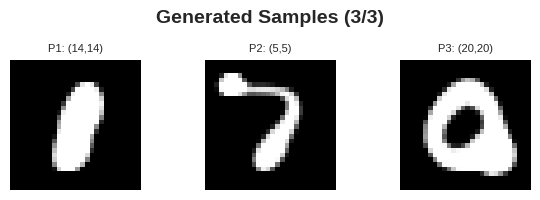

✅ Generated 3 samples!


In [29]:
# @title Generate from Points { run: "auto", vertical-output: true }
points_to_generate_from = [(14, 14), (5, 5), (20, 20)]  # @param

if 'simple_gen' in globals() and simple_gen is not None:
    simple_gen.generate_from_points_list(points_to_generate_from)
else:
    print("Generator not initialized. Please run the setup cell above.")

Computing PCA on real MNIST and projecting generated samples...
Explained variance ratio: [0.09685063 0.07029997 0.06243742]


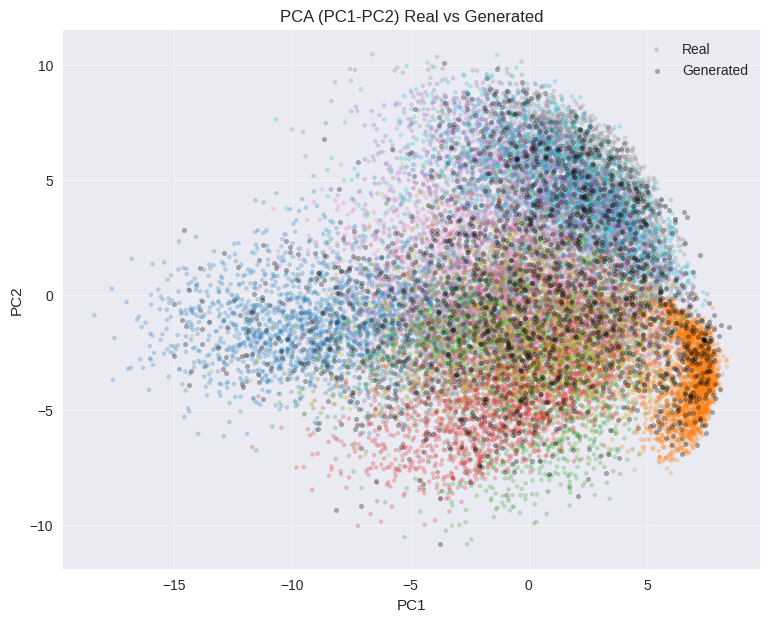

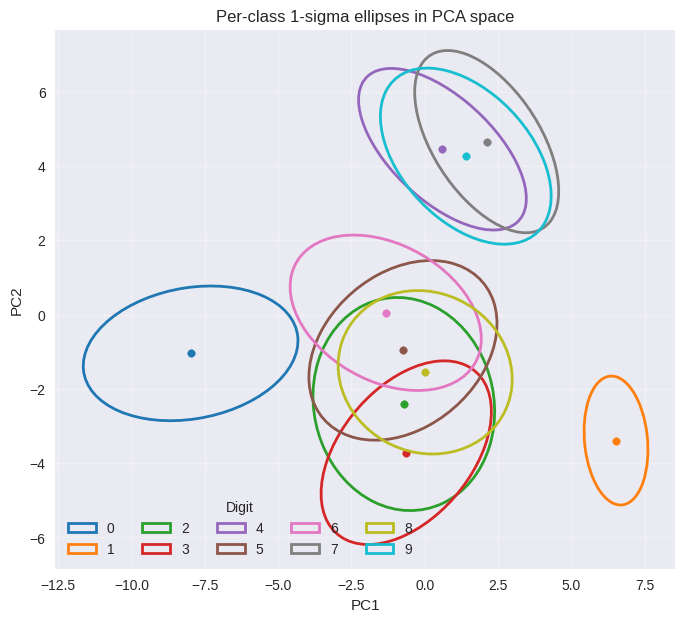

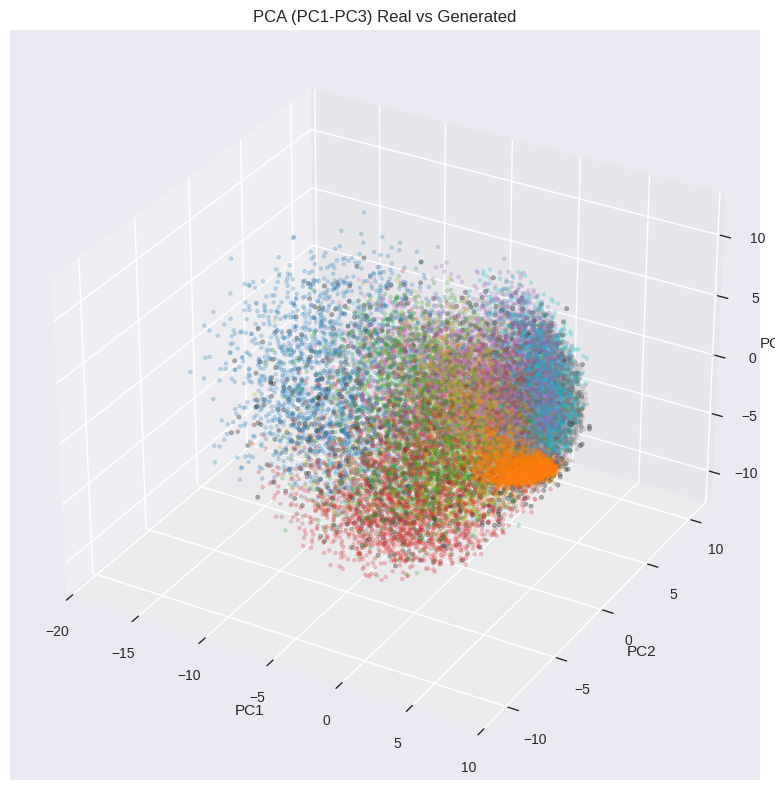

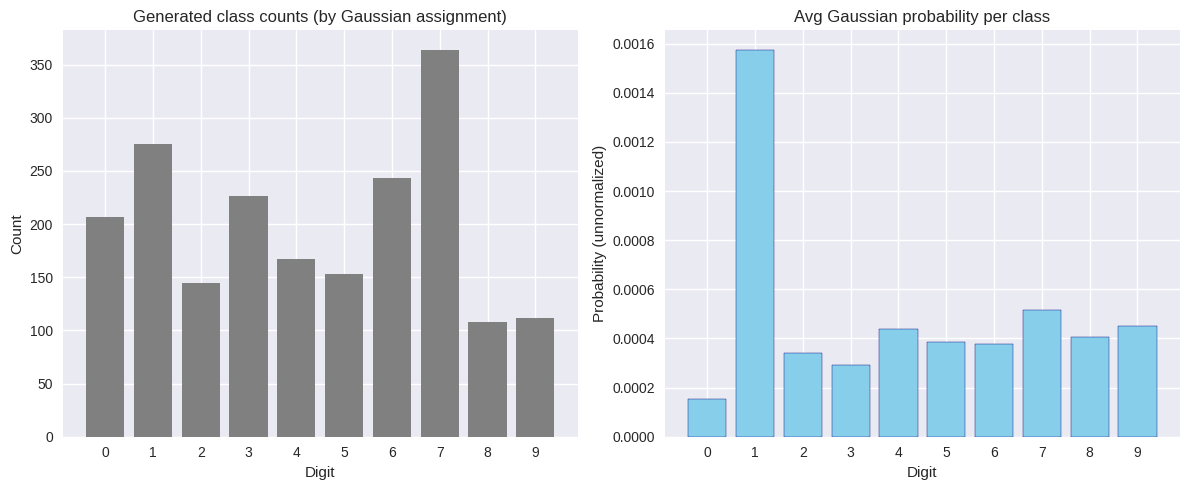

Done.


In [30]:
# ===== PCA projections and analysis =====
print("Computing PCA on real MNIST and projecting generated samples...")

# Fit PCA (PC1-3) on a subset of real training data
pca_result = fit_pca_on_dataset(train_dataset, max_samples=20000, k=3)
mean = pca_result['mean']
components = pca_result['components']
Z = pca_result['Z']
y_real = pca_result['y']
stats = pca_result['stats']
ev_ratio = pca_result['explained_var_ratio']
print(f"Explained variance ratio: {ev_ratio}")

# Generate and project
Zg = project_generated(model, num=2000, steps=60, method='rk4', mean=mean, components=components)

# Classification of generated in PCA space by Gaussian per-class models
y_pred, ll = assign_classes_by_gaussian(Zg, stats)

# Plots
plot_pca_2d(Z[:, :2], y_real, Zg=Zg[:, :2], title="PCA (PC1-PC2) Real vs Generated")
plot_class_gaussians_2d(stats)
plot_pca_3d(Z[:, :3], y_real, Zg=Zg[:, :3], title="PCA (PC1-PC3) Real vs Generated")
plot_probs_and_hist(y_real, y_pred, ll)

print("Done.")